# Forecasting_time_series_data_using_autoregression

* Ref: [https://pythondata.com/forecasting-time-series-autoregression/](https://pythondata.com/forecasting-time-series-autoregression/)
* Data: [https://github.com/urgedata/pythondata/blob/master/examples/retail_sales.csv](https://github.com/urgedata/pythondata/blob/master/examples/retail_sales.csv)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['figure.figsize']=(15, 5)
plt.style.use('ggplot')

## 1. Load data
* In order to load data from google drive, we have to mount google drive
    * See [https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd)

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/retail_sales.csv')
df.head()

,date,sales
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    72 non-null     object
 1   sales   72 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


The type of date column should be datetime and we want to use date as row index.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,sales
date,
2009-10-01,338630
2009-11-01,339386
2009-12-01,400264
2010-01-01,314640
2010-02-01,311022


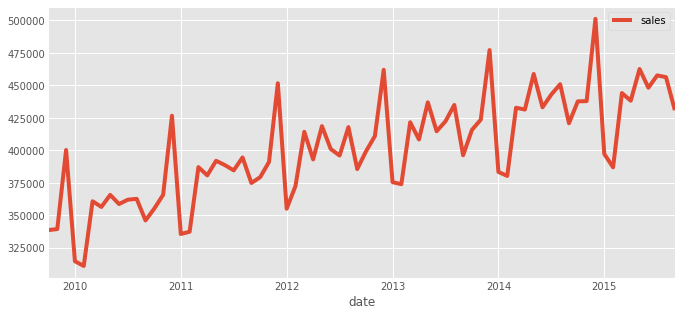

In [ ]:
# Make plot to visualize the sales
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax)
plt.show()

由圖看得出來這有很明顯的 trend 和 seasnality

## 2. Analysis
* The autogression model requires the time series data should be
    * having correlation between time steps
    * stationary (i.e. the mean and variance are constant over time)

### Check the correlation

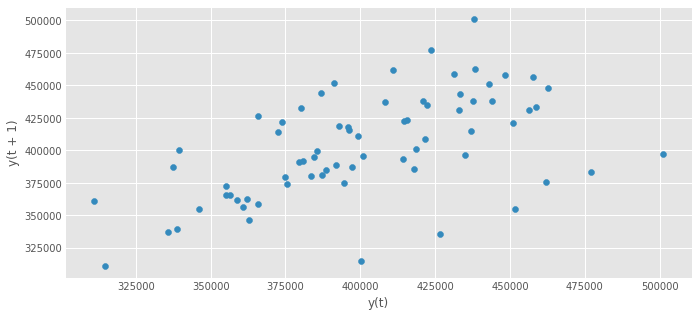

In [ ]:
# Use lag_plot() to check the correlation between time steps
fig, ax = plt.subplots(figsize=(10, 5))
pd.plotting.lag_plot(df['sales'], ax=ax)
plt.show()

依稀看得出來 $y(t)$ 和 $y(t+1)$ 之間是有 correlation 的，但是因為 statistics 不夠多所以不明顯

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:409: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


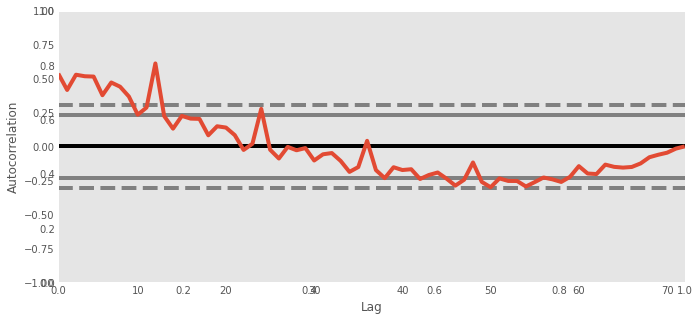

In [ ]:
# Use autocorrelation_plot() to check correlations
fig, ax = plt.subplots(figsize=(10, 5))
pd.plotting.autocorrelation_plot(df['sales'])
plt.show()

* Grey lines are 95% confidence level and grey dashed line are 99% confidence level. The data curve outside the confidence level has significant correlation.

* The lag where data curve first touch the 95% confidence level will be used to train AR. For example, the lag=10 touch the 95% confidence level.

In [ ]:
# Calculate pearson correlation coefficient
df['sales'].corr(df['sales'].shift(12))

0.9790985975895788

From the autocorrelation plot, the highest peak is about lag = 12, so we use `.shift(12)`

### Check the stationarity

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


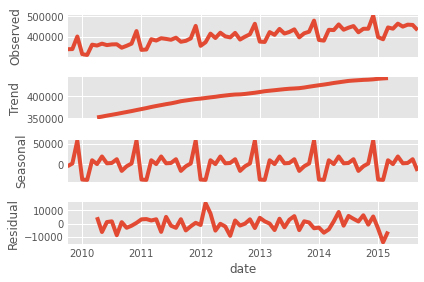

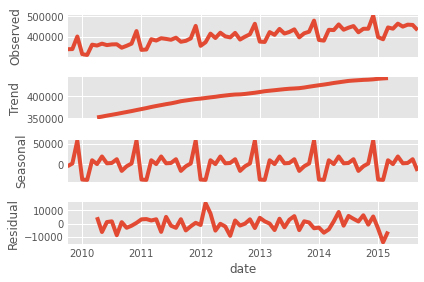

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(df['sales'], model='additive') # what does model for?

decomposed.plot() # Why show the same plot twice?
# 如果用 fig = decomposed.plot() 就只會有一張圖

Because there are trend and seasonality, we have to remove trend and seasonality to make the distribution stationary.

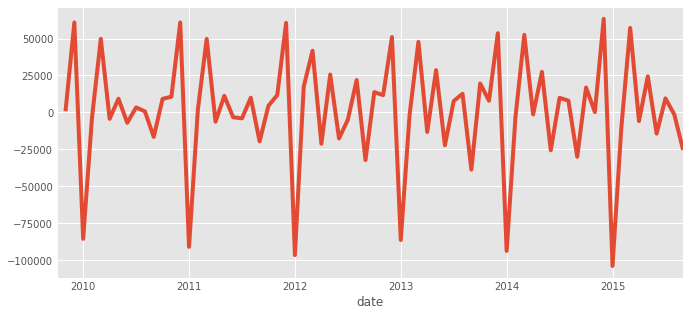

In [ ]:
df['stationary'] = df['sales'].diff()

fig, ax = plt.subplots(figsize=(10, 5))
df['stationary'].plot(ax=ax)
plt.show()

用一次 `.diff()` 之後，trend 就被移除了，所以新的分佈看起來就是 stationary 的

In [ ]:
df.head()

,sales,stationary
date,,
2009-10-01,338630,NaN
2009-11-01,339386,756.0
2009-12-01,400264,60878.0
2010-01-01,314640,-85624.0
2010-02-01,311022,-3618.0


In [ ]:
df.tail()

,sales,stationary
date,,
2015-05-01,462615,24398.0
2015-06-01,448229,-14386.0
2015-07-01,457710,9481.0
2015-08-01,456340,-1370.0
2015-09-01,430917,-25423.0


There is a missing value in the 1st row for stationary column. We have to remove this row before we use `seasonal_decompose()`

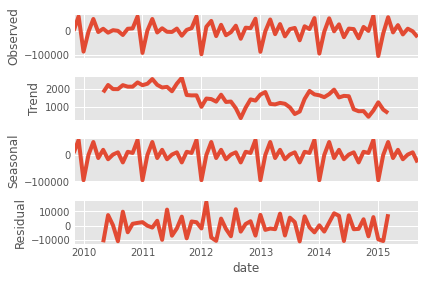

In [ ]:
new_decomposed = seasonal_decompose(df['stationary'].dropna())

# fig, ax = plt.subplots(figsize=(10, 5))
fig = new_decomposed.plot() # assing to fig then there is only one plot
# plt.show()

## 3. Forecast

In [ ]:
# Create train and test dataset
X = df['stationary'].dropna()
print(len(X), X)

# We want to predict the last 12 data points
train = X[1 : len(X) - 12]
# test = X[X[len(X)-12:]]
test = X[len(X)-12:]
print(len(train), train)
print(len(test), test)

71 date
2009-11-01      756.0
2009-12-01    60878.0
2010-01-01   -85624.0
2010-02-01    -3618.0
2010-03-01    49797.0
               ...   
2015-05-01    24398.0
2015-06-01   -14386.0
2015-07-01     9481.0
2015-08-01    -1370.0
2015-09-01   -25423.0
Name: stationary, Length: 71, dtype: float64
58 date
2009-12-01    60878.0
2010-01-01   -85624.0
2010-02-01    -3618.0
2010-03-01    49797.0
2010-04-01    -4359.0
2010-05-01     9253.0
2010-06-01    -7038.0
2010-07-01     3352.0
2010-08-01      655.0
2010-09-01   -16613.0
2010-10-01     9143.0
2010-11-01    10597.0
2010-12-01    60845.0
2011-01-01   -91046.0
2011-02-01     1744.0
2011-03-01    49740.0
2011-04-01    -6338.0
2011-05-01    11216.0
2011-06-01    -3334.0
2011-07-01    -4036.0
2011-08-01     9948.0
2011-09-01   -19653.0
2011-10-01     4469.0
2011-11-01    11717.0
2011-12-01    60588.0
2012-01-01   -96611.0
2012-02-01    17465.0
2012-03-01    41752.0
2012-04-01   -21240.0
2012-05-01    25613.0
2012-06-01   -17652.0
2012-07-01    -

In [ ]:
# Train the autogression model
from statsmodels.tsa.ar_model import AR

model = AR(train)
model_fitted = model.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
print(f'The lag value chose is: {model_fitted.k_ar}')
print(f'The coefficients of the model are:\n {model_fitted.params}')

The lag value chose is: 10
The coefficients of the model are:
 const             7720.952626
L1.stationary       -1.297636
L2.stationary       -1.574980
L3.stationary       -1.403045
L4.stationary       -1.123204
L5.stationary       -0.472200
L6.stationary       -0.014586
L7.stationary        0.564099
L8.stationary        0.792080
L9.stationary        0.843242
L10.stationary       0.395546
dtype: float64


In [ ]:
# Prediction
start=len(train)
end=len(train) + len(test) - 1
print(f'start={start}, end={end}')

predictions = model_fitted.predict(start=start, end=end, dynamic=False)
predictions

start=58, end=69


2014-10-01     5601.811846
2014-11-01    38414.120561
2014-12-01    35441.708285
2015-01-01   -49947.389001
2015-02-01   -21617.841678
2015-03-01    20818.987209
2015-04-01    14274.367772
2015-05-01    15474.495929
2015-06-01   -12799.912704
2015-07-01    10743.906740
2015-08-01     1184.598793
2015-09-01   -23880.339021
Freq: MS, dtype: float64

In [ ]:
df_compare = pd.concat([df['stationary'].tail(12), predictions], axis=1)
df_compare

,stationary,0
2014-10-01,16831.0,5601.811846
2014-11-01,208.0,38414.120561
2014-12-01,63322.0,35441.708285
2015-01-01,-103980.0,-49947.389001
2015-02-01,-10317.0,-21617.841678
2015-03-01,57175.0,20818.987209
2015-04-01,-5893.0,14274.367772
2015-05-01,24398.0,15474.495929
2015-06-01,-14386.0,-12799.912704
2015-07-01,9481.0,10743.906740


In [ ]:
df_compare.rename(columns={'stationary': 'actual',
                           0: 'predicted'},
                  inplace=True)
df_compare

,actual,predicted
2014-10-01,16831.0,5601.811846
2014-11-01,208.0,38414.120561
2014-12-01,63322.0,35441.708285
2015-01-01,-103980.0,-49947.389001
2015-02-01,-10317.0,-21617.841678
2015-03-01,57175.0,20818.987209
2015-04-01,-5893.0,14274.367772
2015-05-01,24398.0,15474.495929
2015-06-01,-14386.0,-12799.912704
2015-07-01,9481.0,10743.906740


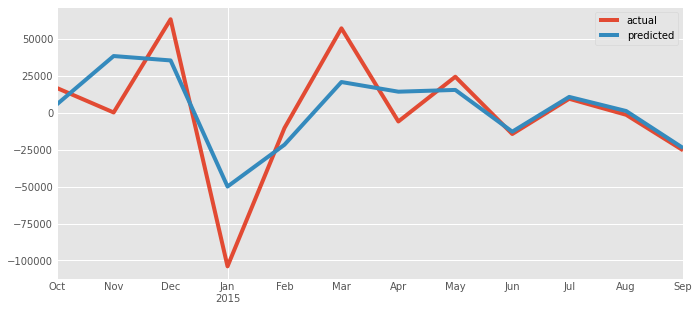

In [ ]:
# Make plot to compare the actual and predicted values
fig, ax = plt.subplots(figsize=(10, 5))
df_compare.plot(ax=ax)
plt.show()

In [ ]:
# Goodness of prediction
from sklearn.metrics import r2_score
r2 = r2_score(df['stationary'].tail(12), predictions)
r2

0.6392721768478096